In [1]:
import pandas as pd

In [2]:
def load_csv_from_github(file_name):
    base_url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/refs/heads/main/"
    return pd.read_csv(base_url + file_name)

In [3]:
tickets_df = load_csv_from_github("anonymized_hubspot_tickets.csv")

In [4]:
tickets_df.columns = [col.strip().lower().replace(" ", "_") for col in tickets_df.columns]

In [5]:
tickets_df.dropna(how="all", inplace=True)

In [6]:
date_cols = [col for col in tickets_df.columns if "date" in col or "time" in col]
for col in date_cols:
    tickets_df[col] = pd.to_datetime(tickets_df[col], errors="coerce")

/var/folders/12/46qydqg93fb95fh7m05jlh540000gn/T/ipykernel_1161/388965820.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tickets_df[col] = pd.to_datetime(tickets_df[col], errors="coerce")
/var/folders/12/46qydqg93fb95fh7m05jlh540000gn/T/ipykernel_1161/388965820.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tickets_df[col] = pd.to_datetime(tickets_df[col], errors="coerce")
/var/folders/12/46qydqg93fb95fh7m05jlh540000gn/T/ipykernel_1161/388965820.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tickets_df[col] = pd.to_datetime(tickets_df[col], errors="coerce")


In [7]:
tickets_df["implementation_duration_days"] = (
    tickets_df["close_date"] - tickets_df["create_date"]
).dt.days

In [8]:
tickets_df["is_complete"] = tickets_df["implementation_duration_days"].notna()

In [9]:
drop_cols = ['was_the_sym_qaed?', 'ticket_tags', 'category']
tickets_df.drop(columns=drop_cols, inplace=True)

In [10]:
tickets_df['has_priority'] = tickets_df['priority'].notna().astype(int)
tickets_df['has_trial_required'] = tickets_df['trial_required'].notna().astype(int)
tickets_df['has_training_reporting'] = tickets_df['training:_reporting'].notna().astype(int)
tickets_df['has_training_sym201'] = tickets_df['training:_sym_building_201'].notna().astype(int)
tickets_df['responded_syms_creator'] = tickets_df['who_will_be_creating_the_syms?'].notna().astype(int)

In [11]:
print("Shape:", tickets_df.shape)
print("Remaining missing values:")
print(tickets_df.isnull().sum().sort_values(ascending=False).head(10))

Shape: (79, 50)
Remaining missing values:
last_ces_survey_rating                        79
stage_date_-_monitoring_and_control_phase     79
stage_date_-_planning_phase                   79
type                                          78
trial_required                                78
priority                                      78
time_to_close_(hh:mm:ss)                      77
who_will_be_creating_the_syms?                76
response_time_(hh:mm:ss)                      69
time_to_first_agent_email_reply_(hh:mm:ss)    69
dtype: int64


In [12]:
tickets_df['ticket_status'].value_counts()

ticket_status
Converted-Won                   30
Lost                            22
Execution Phase                  7
Planning Phase                   6
Monitoring and Control Phase     6
Closure Phase                    3
Project Initiation Phase         3
Project Launch                   2
Name: count, dtype: int64

In [13]:
tickets_df.groupby('ticket_status')['implementation_duration_days'].mean().sort_values()

ticket_status
Lost                            101.454545
Converted-Won                   116.600000
Closure Phase                   174.333333
Execution Phase                        NaN
Monitoring and Control Phase           NaN
Planning Phase                         NaN
Project Initiation Phase               NaN
Project Launch                         NaN
Name: implementation_duration_days, dtype: float64

In [14]:
tickets_df['is_complete'].value_counts(normalize=True)

is_complete
True     0.696203
False    0.303797
Name: proportion, dtype: float64

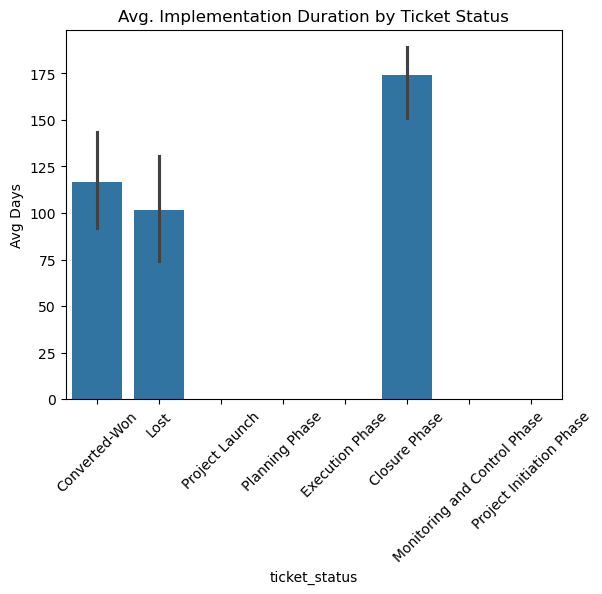

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Barplot of duration by status
sns.barplot(data=tickets_df, x='ticket_status', y='implementation_duration_days', estimator='mean')
plt.xticks(rotation=45)
plt.title("Avg. Implementation Duration by Ticket Status")
plt.ylabel("Avg Days")
plt.show()

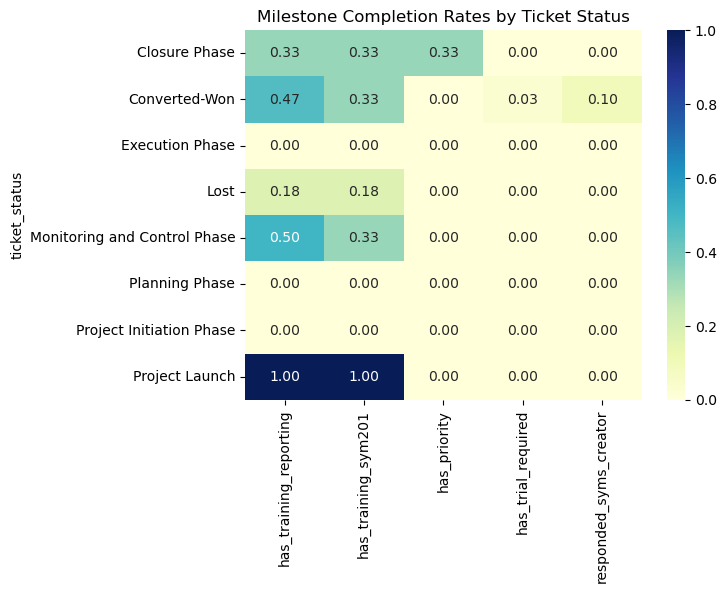

In [16]:
# Visualizing training and milestone completion rates by outcome
milestone_cols = [
    'has_training_reporting',
    'has_training_sym201',
    'has_priority',
    'has_trial_required',
    'responded_syms_creator'
]

sns.heatmap(
    tickets_df.groupby('ticket_status')[milestone_cols].mean(),
    annot=True, cmap='YlGnBu', fmt=".2f"
)
plt.title("Milestone Completion Rates by Ticket Status")
plt.show()

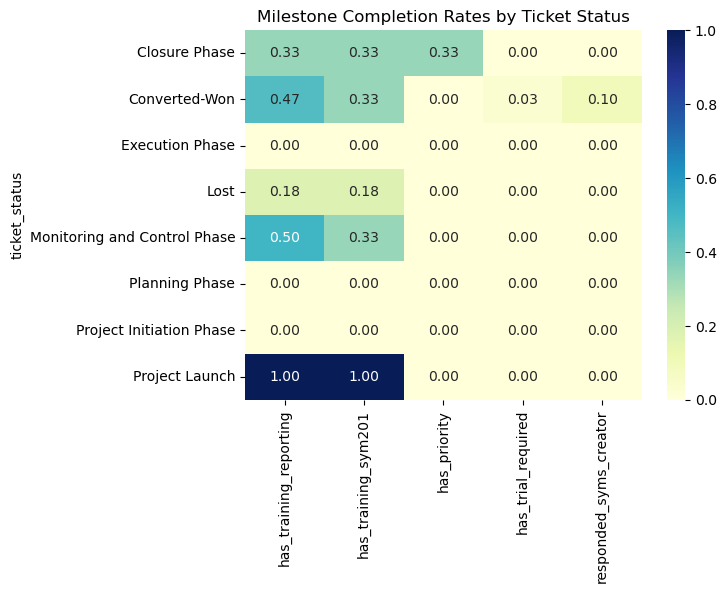

In [17]:
# Visualizing training and milestone completion rates by outcome
milestone_cols = [
    'has_training_reporting',
    'has_training_sym201',
    'has_priority',
    'has_trial_required',
    'responded_syms_creator'
]

sns.heatmap(
    tickets_df.groupby('ticket_status')[milestone_cols].mean(),
    annot=True, cmap='YlGnBu', fmt=".2f"
)
plt.title("Milestone Completion Rates by Ticket Status")
plt.show()

In [18]:
# Flag tickets that are incomplete AND old
tickets_df['at_risk'] = (tickets_df['is_complete'] == False) & (tickets_df['create_date'] < pd.to_datetime('2024-12-01'))

# See which types are most at-risk
tickets_df['at_risk'].value_counts()
tickets_df[tickets_df['at_risk'] == True]['ticket_status'].value_counts()

ticket_status
Monitoring and Control Phase    4
Planning Phase                  2
Execution Phase                 2
Project Initiation Phase        2
Project Launch                  1
Name: count, dtype: int64